In [125]:
import xml.etree.ElementTree as ET
root = ET.parse('torusFirst.xml').getroot()
principal_directions0 = root.findall("principalDirections0")[0]
principal_directions1 = root.findall("principalDirections1")[0]
principal_directions2 = root.findall("principalDirections2")[0]
principal_directions3 = root.findall("principalDirections3")[0]
vertex_positions = root.findall("vertexPositions")[0]
normals = root.findall("normals")[0]

In [76]:
import numpy as np

In [77]:
principal_directions0[0][0].text

'-0.587781131'

In [126]:
vertices = []
unity_normals = []
unity_values1 = []
unity_values2 = []
unity_values3 = []
unity_values4 = []

x_index=0
y_index=2
z_index=1

for i in range(len(principal_directions0)):
    vp = vertex_positions[i]
    vp_val = np.asarray([float(vp[x_index].text), float(vp[y_index].text), float(vp[z_index].text)])
    
    #if not any((vp_val == x).all() for x in vertices):
    vertices.append(vp_val)
    
    n = normals[i]
    n_val = np.asarray([float(n[x_index].text), float(n[y_index].text), float(n[z_index].text)])
    
    pd1 = principal_directions0[i]
    pd1_val = np.asarray([float(pd1[x_index].text), float(pd1[y_index].text), float(pd1[z_index].text)])

    pd2 = principal_directions1[i]  
    pd2_val = np.asarray([float(pd2[x_index].text), float(pd2[y_index].text), float(pd2[z_index].text)])

    pd3 = principal_directions2[i]  
    pd3_val = np.asarray([float(pd3[x_index].text), float(pd3[y_index].text), float(pd3[z_index].text)])

    pd4 = principal_directions3[i]  
    pd4_val = np.asarray([float(pd4[x_index].text), float(pd4[y_index].text), float(pd4[z_index].text)])

    unity_values1.append(pd1_val)
    unity_values2.append(pd2_val)
    unity_values3.append(pd3_val)
    unity_values4.append(pd4_val)
    unity_normals.append(n_val)

print("Vertices: {}".format(len(vertices)))

Vertices: 2400


Max x: 0.750000238
Max y: 0.7500002
Max z: 0.25000003


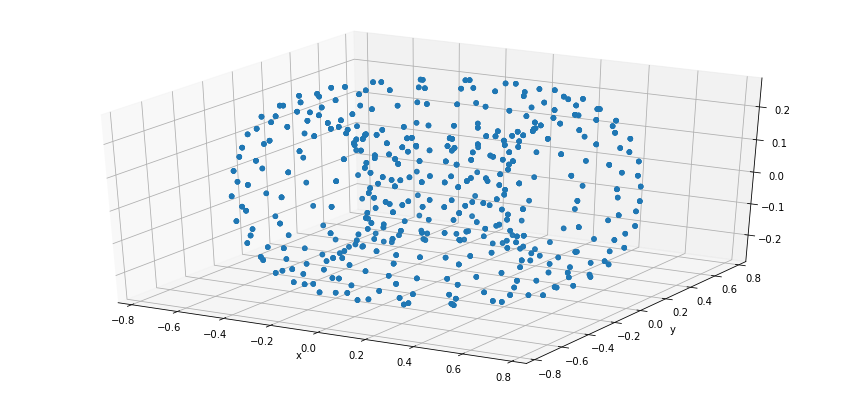

In [132]:
import matplotlib.pyplot as plt
stack = np.stack(vertices)
fig = plt.figure(figsize=(15,7))
ax = plt.axes(projection="3d")
ax.scatter(stack[:, 0], stack[:, 1], stack[:, 2])
plt.xlabel('x')
plt.ylabel('y')

print("Max x:", np.amax(stack[:, 0]))
print("Max y:", np.amax(stack[:, 1]))
print("Max z:", np.amax(stack[:, 2]))

plt.show()

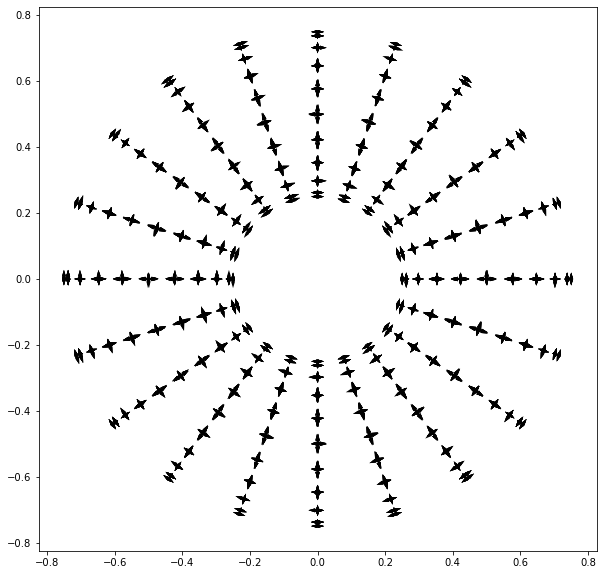

In [133]:
vert_stack = np.stack(vertices)
curv_stack1 = np.stack(unity_values1)
curv_stack2 = np.stack(unity_values2)
curv_stack3 = np.stack(unity_values3)
curv_stack4 = np.stack(unity_values4)

fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack1[:,0], curv_stack1[:,1])#, headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack2[:,0], curv_stack2[:,1])#, headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack3[:,0], curv_stack3[:,1])#, headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack4[:,0], curv_stack4[:,1])#, headwidth=1, width=0.001, scale=60)

plt.show()

In [140]:
from math import sin, cos, atan2, asin, acos, sqrt

r1 = 0.5
r2 = 0.25

def len_vector(v):
    return np.sqrt(np.sum(v**2))

def normalize(v):
    return v / len_vector(v)

def diff(v1, v2):
    diff1 = len_vector(v1-v2)
    diff2 = len_vector(v1+v2)
    return min(diff1, diff2)

diffs = []
analitic_curv1 = []
analitic_curv2 = []

for i in range(len(vertices)):
    vertex = vertices[i]    
    
    x = vertex[0]
    y = vertex[1]
    z = vertex[2] #up
    
    p1_unity = normalize(unity_values1[i])
    p2_unity = normalize(unity_values2[i])
    
    l = atan2(y, x)
    cos_l = cos(l)
    sin_l = sin(l) 
    
    sin_o = z/r2
    cos_o = np.sqrt(abs(1 - sin_o**2))
    dist = x**2 + y**2
    if dist <= r1**2:
        cos_o *= -1
                
    p1 = np.asarray([-sin_l, cos_l, 0])
    p2 = np.asarray([-cos_l*sin_o, -sin_o*sin_l, cos_o])
    p1 = normalize(p1)  
    p2 = normalize(p2)
    
    diffs.append([diff(p1, p1_unity), diff(p2, p2_unity)])
    analitic_curv1.append(p1)
    analitic_curv2.append(p2)

vert_stack = np.stack(vertices)
curv_stack1_a = np.stack(analitic_curv1)
curv_stack2_a = np.stack(analitic_curv2)


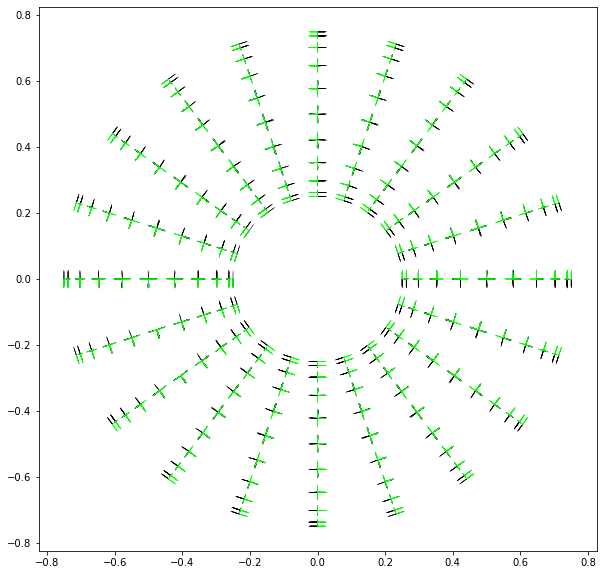

In [141]:
fig, ax = plt.subplots(figsize=(10,10))

ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack1[:,0], curv_stack1[:,1], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack2[:,0], curv_stack2[:,1], headwidth=1, width=0.001, scale=60)

ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack1_a[:,0], curv_stack1_a[:,1], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))
ax.quiver(vert_stack[:,0], vert_stack[:,1], curv_stack2_a[:,0], curv_stack2_a[:,1], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))

plt.show()

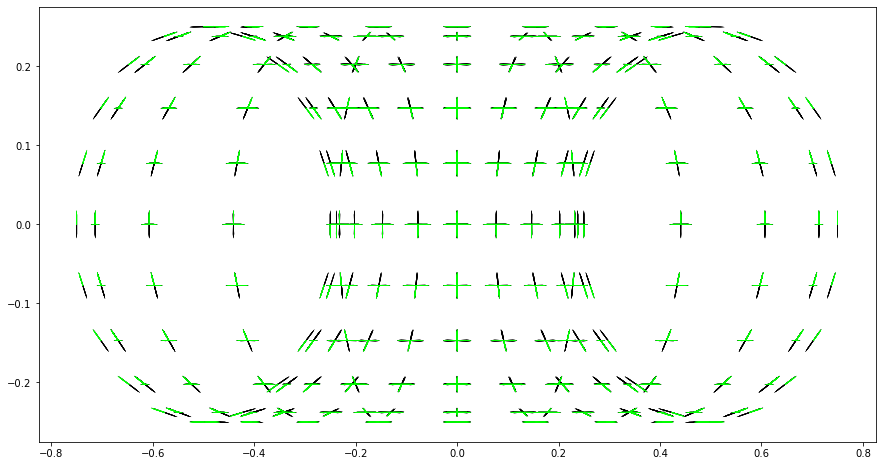

In [142]:
fig, ax = plt.subplots(figsize=(15,8))

ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack1[:,0], curv_stack1[:,2], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack2[:,0], curv_stack2[:,2], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack3[:,0], curv_stack3[:,2], headwidth=1, width=0.001, scale=60)
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack4[:,0], curv_stack4[:,2], headwidth=1, width=0.001, scale=60)

ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack1_a[:,0], curv_stack1_a[:,2], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))
ax.quiver(vert_stack[:,0], vert_stack[:,2], curv_stack2_a[:,0], curv_stack2_a[:,2], headwidth=1, width=0.001, scale=60, color=(0, 1, 0))

plt.show()

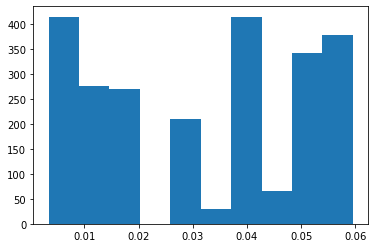

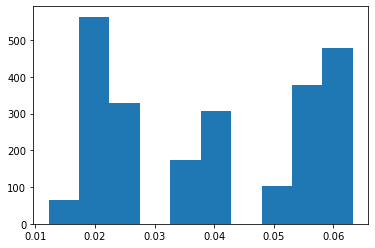

2400


In [143]:
diff_stack = np.stack(diffs)
plt.hist(diff_stack[:, 0])
plt.show()

plt.hist(diff_stack[:, 1])
plt.show()

print(len(diff_stack[:, 0]))

for i in range(len(diff_stack[:, 0])):
    if diff_stack[i, 0] > 1:
        print(i, diff_stack[i, 0])

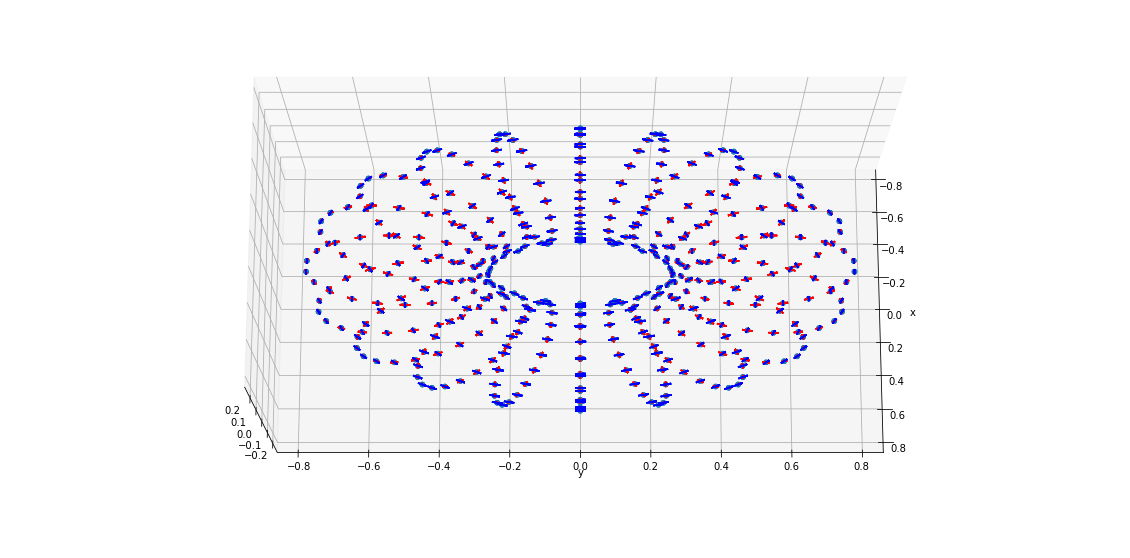

In [150]:
def plot_tangent(pp, tt1, tt2, a=75, b=0):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection="3d")
    ax.view_init(a, b)
    ax.set_proj_type('persp')
    
    ax.scatter(pp[:, 0], pp[:, 1], pp[:, 2])
    
    pp2 = np.tile(pp,(2,1))
#     ax.quiver(pp2[:,0], pp2[:,1], pp2[:,2], tt2[:,0], tt2[:,1], tt2[:,2], pivot='middle', length=0.4)
    ax.quiver(pp[:,0], pp[:,1], pp[:,2], tt1[:,0], tt1[:,1], tt1[:,2],
                colors='blue',
              pivot='middle', length=0.03)
    ax.quiver(pp[:,0], pp[:,1], pp[:,2], tt2[:,0], tt2[:,1], tt2[:,2],
                colors='red',
              pivot='middle', length=0.03)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
plot_tangent(vert_stack, curv_stack1_a, curv_stack2_a)

In [145]:
print(vert_stack[30], curv_stack1_a[30], curv_stack2_b[30])

NameError: name 'curv_stack2_b' is not defined

In [147]:
from xml.etree.ElementTree import Element, SubElement, tostring
from bs4 import BeautifulSoup

#"principalDirections0" curv_stack1_a
#"principalDirections1" curv_stack2_b
#"principalDirections2"
#"principalDirections3"
#"vertexPositions" vert_stack
normal_stack = np.stack(unity_normals)


storedCurvature = Element("StoredCurvature")

principalDirections0 = SubElement(storedCurvature, "principalDirections0")
principalDirections1 = SubElement(storedCurvature, "principalDirections1")
principalDirections2 = SubElement(storedCurvature, "principalDirections2")
principalDirections3 = SubElement(storedCurvature, "principalDirections3")
vertexPositions = SubElement(storedCurvature, "vertexPositions")
normals = SubElement(storedCurvature, "normals")


for i in range(len(vert_stack)):
    pd0 = curv_stack1_a[i]
    pd1 = curv_stack2_a[i]
    pd2 = -1*curv_stack1_a[i]
    pd3 = -1*curv_stack2_a[i]
    vert = vert_stack[i]
    normal = normal_stack[i]
    
    subelements = [vertexPositions, principalDirections0, principalDirections1, principalDirections2, principalDirections3, normals]
    values = [vert, pd0, pd1, pd2, pd3, normal]
    
    for element, value in zip(subelements, values):
        Vector3 = SubElement(element, "Vector3")
        x_comp = SubElement(Vector3, "x")
        x_comp.text = str(value[x_index])
        y_comp = SubElement(Vector3, "y")
        y_comp.text = str(value[y_index])
        z_comp = SubElement(Vector3, "z")
        z_comp.text = str(value[z_index])

xml_text = tostring(storedCurvature)
bs = BeautifulSoup(xml_text, 'xml')

with open("AnaliticFirstTorus.xml", "wb") as f:
    f.write(bs.prettify().encode())